In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from pandas import Series
import pandas as pd
import numpy as np
import datetime
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, log_loss

# **Загружаем данные**

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [7]:
# Объединим train и test
train['sample'] = 1
test['sample'] = 0
test['default'] = -1
data = train.append(test, sort=False).reset_index(drop=True)
data.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


# **Посмотрим на данные**

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [10]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] # числовые признаки
cat_cols = ['education','work_address','home_address','sna','first_time'] # категориальные признаки
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # бинарные признаки

> **Посмотрим на распределение числовых признаков**

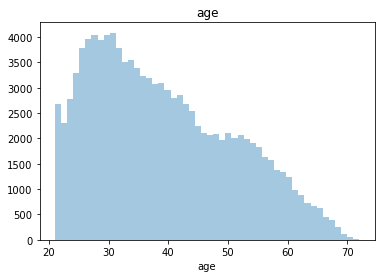

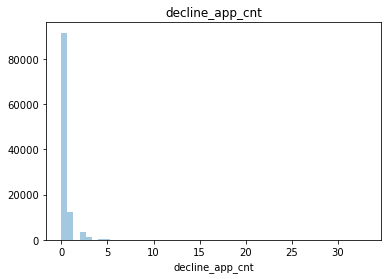

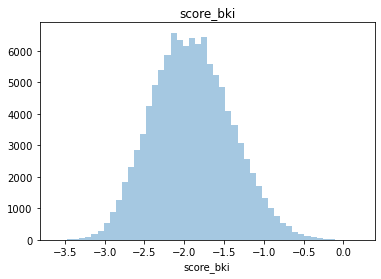

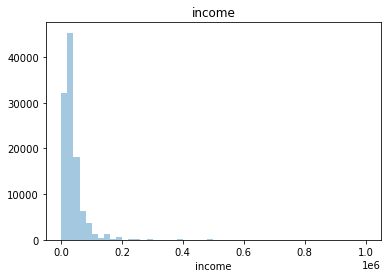

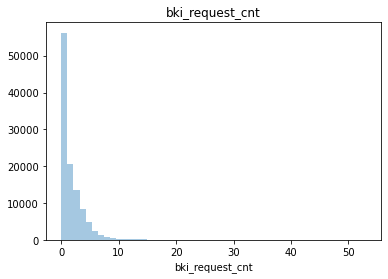

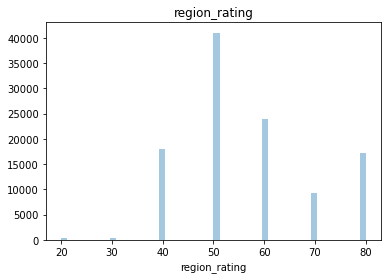

In [11]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False)
    plt.title(i)
    plt.show()

Видно, что признаки age, score_bki, rating_region распределены нормально. Оставшиеся признаки прологорифмируем, чтобы получить более нормальное распределение.

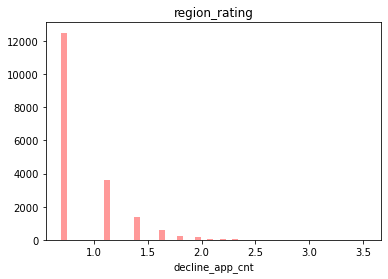

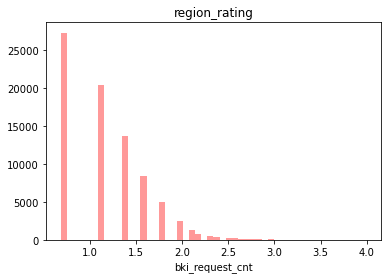

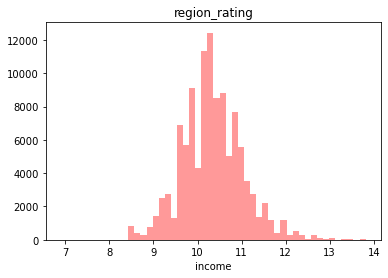

In [12]:
for col in ['decline_app_cnt', 'bki_request_cnt', 'income']:
    data[col] = np.log(data[col] + 1)
    plt.figure()
    sns.distplot(data[col][data[col] > 0].dropna(),kde = False, rug=False,color="r")
    plt.title(i)
    plt.show()

Видно, что income распределено почти колоколом, это хорошо. С decline_app_cnt и bki_requests_cnt почти ничего не поменялось, но стало однозначно лучше

Посмотрим на выбросы, с помощью boxplot.

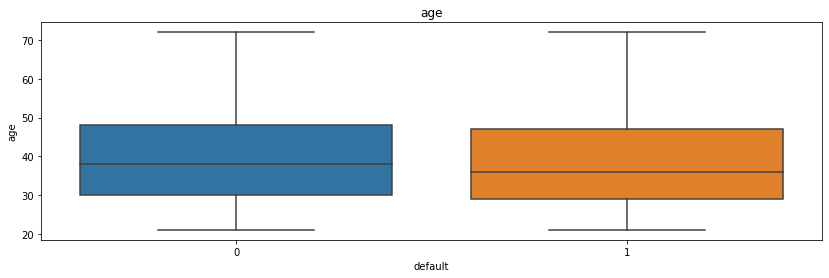

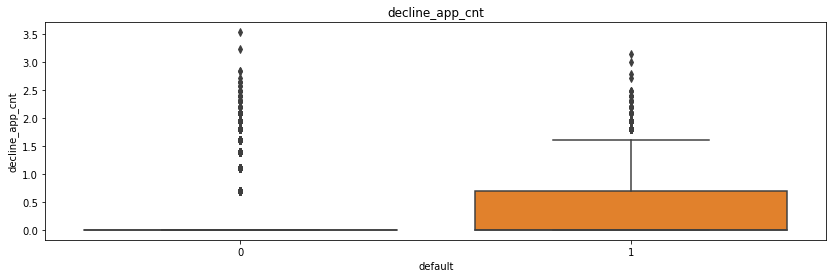

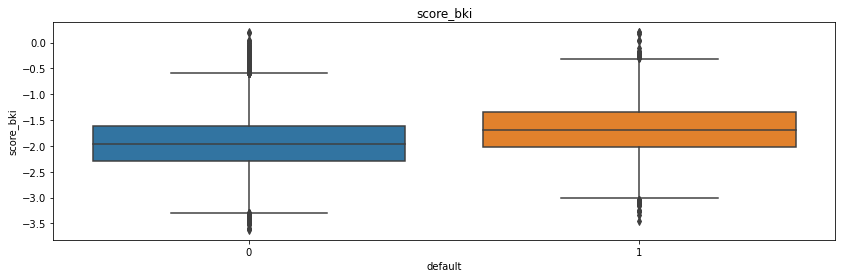

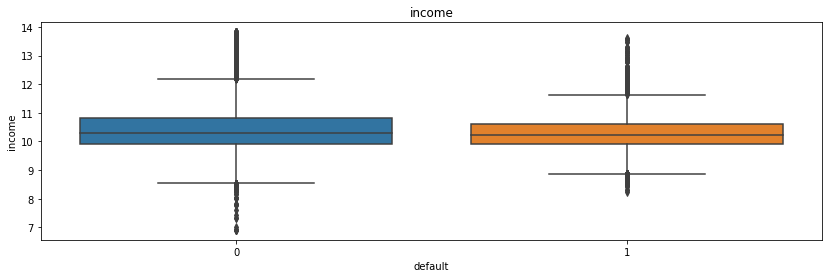

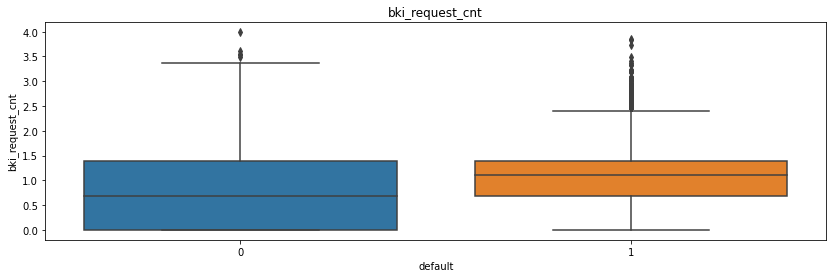

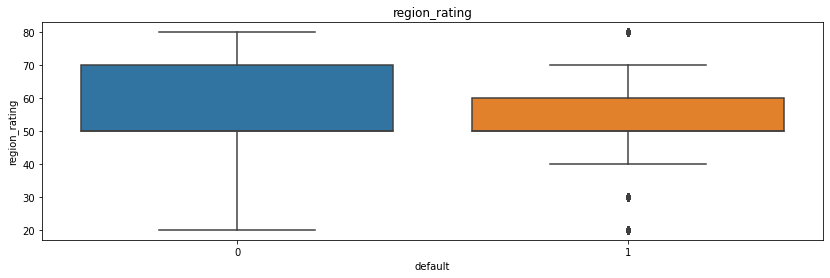

In [13]:
def boxplot(col):
    fig, axes = plt.subplots(figsize=(14,4))
    sns.boxplot(x='default',y=col, data=data[data['sample']==1],ax=axes)
    axes.set_title(col)
    plt.show()
    
for i in num_cols:
    boxplot(i)
    


Из графиков видно, что люди, которые являются надёжными заёмщиками(default=0): 1)старше
2)у них меньше кол-во отказанных заявок 3)меньше среднее кол-во запросов в БКИ 4)скоринговый балл по данным БКИ ниже. 5) выше зп.


> **Проверим категориальные признаки**

Пропущенных значений: 478


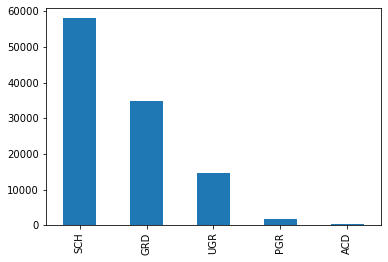

In [14]:
#В education у нас есть пропуски
data.education.value_counts().plot(kind='bar')
print('Пропущенных значений:',data.education.isna().sum())

Заменим пропущенные значения на медиану

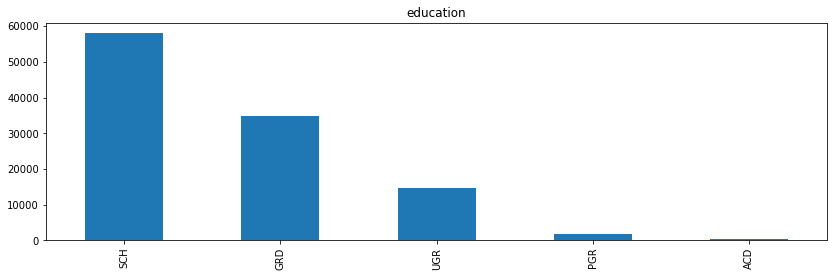

education: ['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan]


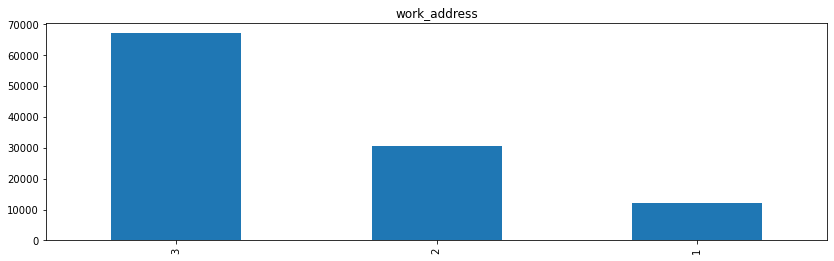

work_address: [2, 3, 1]


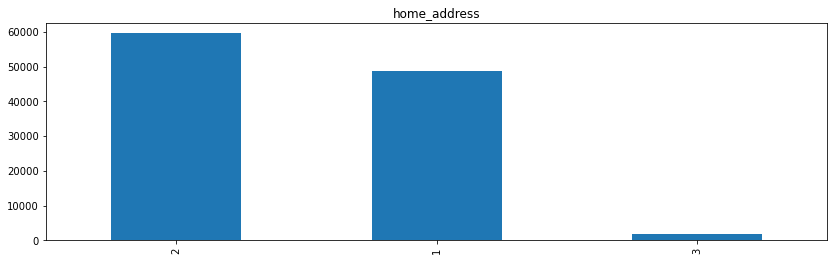

home_address: [1, 2, 3]


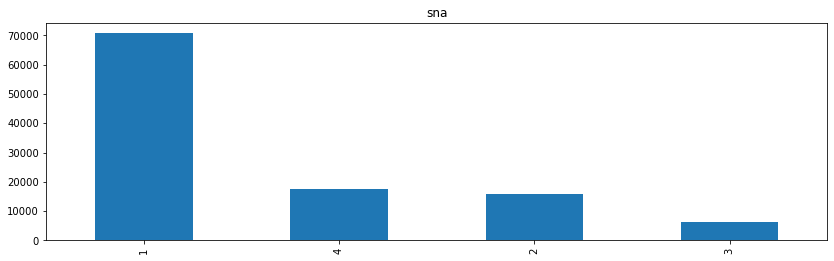

sna: [4, 1, 2, 3]


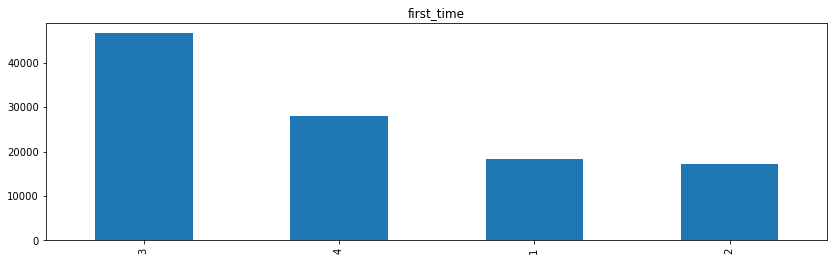

first_time: [1, 4, 3, 2]


In [15]:
# посмотрим на уникальные значения
for i in cat_cols:
    plt.figure(figsize=(14,4))
    data[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()
    print(i+':',data[i].unique().tolist())

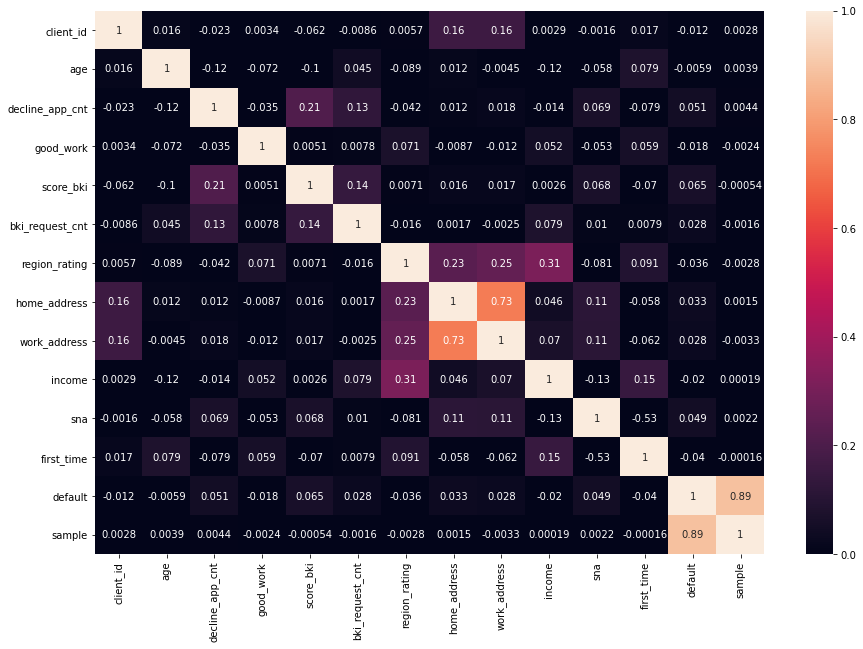

In [16]:
# посмотрим на корреляцию признаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot=True)

In [17]:
# Признаки home_address и work_address имеют сильную зависимость, в будущем посмотрим
# какой из этих признаков более хорошо подходит для модели и удалим худший из них.

# **Future engineering**

In [18]:
data.app_date = pd.to_datetime(data.app_date)
data['days_from_now'] = (datetime.datetime.today()-data.app_date) #Кол-во дней с настоящего момента
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days)

In [19]:
data.days_from_now = data.days_from_now.apply(lambda x: x.days)

In [20]:
data.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,days_from_now
0,25905,31,SCH,M,62,Y,Y,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,N,0,1,2643
1,63161,70,SCH,F,59,N,N,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,N,0,1,2604
2,25887,31,SCH,M,25,Y,N,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,Y,0,1,2643
3,16222,22,SCH,F,53,N,N,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,N,0,1,2652
4,101655,107,GRD,M,48,N,N,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,Y,0,1,2567


Попробуем построить новые признаки, после проверим какие из них наиболее значимы

In [21]:
df = data.copy() # сделаем копию датасета, пока что будем работать с ним

In [22]:
# признак по средней заработной плате для каждого возраста
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)

In [23]:
# признак по максимальной зарплате для каждого возраста
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)

In [24]:
# нормализируем признак зп по возрасту
df["normalized_income"] = abs((df.income - df.mean_income_age)/df.max_income_age)

In [25]:
# среднее кол-во запросов в БКИ по возрасту
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [26]:
# среднее кол-во запросов по зп
mean_bki_inc = df.groupby('income')['bki_request_cnt'].mean().to_dict()
df['mean_requests_income'] = df['income'].map(mean_bki_inc)

In [27]:
# Средняя зп по рейтингу региона
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

# **Encoding**

In [28]:
def encoding_bin(data1,col):
    """Возвращает словарь, где ключ - бинарный признак, а значение - свой номер"""
    dict_unique = {}
    
    for k,i in enumerate(data1[col].unique().tolist()):
        dict_unique[i] = k
        
    return dict_unique

In [29]:
# пример, что выводит функция
encoding_bin(data1=df,col='sex')

{'M': 0, 'F': 1}

In [30]:
for i in bin_cols:
    df[i] = df[i].map(encoding_bin(data1=df, col=i))

In [31]:
df['education'] = df['education'].map(encoding_bin(data1=df, col='education'))

In [32]:
# В education пропущенные значения заменились цифрой 5 заменим на медиану
df[df['education']==5]['education'] = df['education'].mode().values[0]

<ipython-input-32-7a85358068cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['education']==5]['education'] = df['education'].mode().values[0]


In [33]:
# добавим в список с численными признаками, новые признаки
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt', 'mean_income_age','region_rating','max_income_age', 'normalized_income',
       'mean_requests_age', 'mean_requests_income', 'mean_income_region','days_from_now','app_date']

# **Найдём выбросы, заменим их (для численных признаков)**

In [34]:
def find_outliers(data1, col):
    Q1, Q3 = data1[col].quantile(0.25), data1[col].quantile(0.75)
    IQR = np.abs(Q3-Q1)
    return (Q1-1.5*IQR,Q3+1.5*IQR)

In [35]:
for i in num_cols:
    print(i,':',find_outliers(data1=df, col=i))

age : (3.0, 75.0)
decline_app_cnt : (0.0, 0.0)
score_bki : (-3.299251946250001, -0.5290698762499992)
income : (8.590378193705899, 12.092136480586621)
bki_request_cnt : (-2.0794415416798357, 3.465735902799726)
mean_income_age : (10.096765980049959, 10.653013305170418)
region_rating : (35.0, 75.0)
max_income_age : (12.661925126223323, 14.506062618075909)
normalized_income : (-0.04718592286031794, 0.11445767712175765)
mean_requests_age : (0.7636162786736559, 1.041442994787427)
mean_requests_income : (0.7391870597717735, 1.0200299604316054)
mean_income_region : (10.102755076576383, 10.383648976503782)
days_from_now : (2501.0, 2725.0)
app_date : (-51.0, 173.0)


In [36]:
# найдём строки, в которых есть выбросы
for i in num_cols:
    lower_out = find_outliers(data1=df, col=i)[0]
    upper_out = find_outliers(data1=df, col=i)[1]
    df_out = len(df[(df[i]<lower_out)|(df[i]>upper_out)][i].values)
    print(i.upper()+':',df_out,'\n')

AGE: 0 

DECLINE_APP_CNT: 18677 

SCORE_BKI: 518 

INCOME: 2609 

BKI_REQUEST_CNT: 15 

MEAN_INCOME_AGE: 9071 

REGION_RATING: 17917 

MAX_INCOME_AGE: 4443 

NORMALIZED_INCOME: 3630 

MEAN_REQUESTS_AGE: 8651 

MEAN_REQUESTS_INCOME: 6508 

MEAN_INCOME_REGION: 26908 

DAYS_FROM_NOW: 0 

APP_DATE: 0 



Выбросов в данных много и часть из них наверняка есть в тестовой выборке. Удалять не вариант

decline_app_cnt

In [37]:
# В тренировочной выборке такие данные
df[df['sample']==1]['decline_app_cnt'].value_counts()

0.000000    61214
0.693147     8397
1.098612     2468
1.386294      903
1.609438      414
1.791759      165
1.945910      113
2.079442       48
2.302585       24
2.197225       19
2.397895       11
2.484907        9
2.639057        3
2.708050        2
2.833213        2
2.564949        2
2.772589        1
3.218876        1
3.526361        1
2.995732        1
3.135494        1
Name: decline_app_cnt, dtype: int64

In [38]:
# В тестовой выборке такие данные 
df[df['sample']==0]['decline_app_cnt'].value_counts()

0.000000    30257
0.693147     4103
1.098612     1154
1.386294      462
1.609438      192
1.791759       90
1.945910       43
2.197225       18
2.079442       10
2.397895        5
2.302585        5
2.564949        3
2.484907        1
2.708050        1
3.091042        1
3.433987        1
2.639057        1
3.044522        1
2.833213        1
Name: decline_app_cnt, dtype: int64

В decline_app_cnt выбросами являются все значения отличные от 0, это получилось из-за того, что очень много значений 0 в данных. Если бы это было не соревнование на kaggle, то я бы в обоих выборках удалил строки, значения которых встречаются очень мало раз. Но в нашем случае так делать нельзя, поэтому придётся оставить эти строки в test. Чтобы модель на предсказании не "удивлялась" таким данным, придётся оставить и в train эти строки, это, конечно, почти никак не повлияет на результат, т.к. таких данных слишком мало, но всё же. 

SCORE_BKI

In [39]:
def replace_for_median(data1, col):
    """Заменяет выбросы на медиану, если это улучшит значимость признака"""
    try:
        df_train = data1[data1['sample']==1] # выбираем только строки, где была известа default.
        
        # считаем значимость переменной до замены
        significance_before = pd.Series(f_classif(df_train[num_cols], df_train['default'])[0], index = num_cols)[col]
        
        # находим верхние и нижние границы до замены.
        lower_out = find_outliers(data1=data1, col=col)[0]
        upper_out = find_outliers(data1=data1, col=col)[1]
        
        # находим индексы строк, в которых есть выбросы
        index_list = data1[(data[col]<lower_out)|(data1[col]>upper_out)][col].index
        
        # сделаем копию датасета для проверки
        data1_copy = data1.copy()
        
        # заменяем выбросы на медиану в копии
        data1_copy.loc[index_list,col] = data1_copy.loc[index_list][col].apply(lambda x: data1_copy[col].median())
        data1_copy = data1_copy[data1_copy['sample']==1]
        
        significance_after = pd.Series(f_classif(data1_copy[num_cols], data1_copy['default'])[0], index = num_cols)[col]
        
        if significance_before <= significance_after:
            print('Значимость переменной улучшилась')
            data1.loc[index_list,col] = data1.loc[index_list][col].apply(lambda x: data1[col].median())
            
            # если после замены границы не совпадают, значит замена прошла успешно и выводится сообщение об этом.
            lower_out2 = find_outliers(data1=data1, col=col)[0]
            upper_out2 = find_outliers(data1=data1, col=col)[1]
            
            if (lower_out2 != lower_out) and (upper_out2 != upper_out):
                return 'Function replaced values successfully'
        else: return('Значимость модели не улучшилась, поэтому замены не произошло')
        
        
    except: return 'Error message'
        

In [40]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='score_bki')[0]
upper_out = find_outliers(data1=df, col='score_bki')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['score_bki']<lower_out)|(df['score_bki']>upper_out))]['score_bki']

Границы: -3.299251946250001 -0.5290698762499992


56      -0.500103
80      -0.266137
235     -0.275273
429     -0.523215
446     -0.523830
           ...   
72993   -0.012303
73265   -0.470095
73367   -0.281990
73478   -3.395724
73644   -0.459329
Name: score_bki, Length: 340, dtype: float64

In [41]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='score_bki')[0]
upper_out = find_outliers(data1=df, col='score_bki')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['score_bki']<lower_out)|(df['score_bki']>upper_out))]['score_bki']

Границы: -3.299251946250001 -0.5290698762499992


73912    -0.138353
73955    -0.336232
74064    -0.504570
74504    -0.475228
74635    -0.113810
            ...   
108867   -0.381574
109604   -3.543406
109720   -0.454367
109829   -0.525054
110025   -0.305878
Name: score_bki, Length: 178, dtype: float64

In [42]:
# Заменим в train и test выбросы на медиану, т.к. в тестовой выборке мало выбросов и медиана не будет равняться моде, в отличие от decline_app_cnt.
replace_for_median(data1=df, col='score_bki')

'Значимость модели не улучшилась, поэтому замены не произошло'

INCOME

In [43]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='income')[0]
upper_out = find_outliers(data1=df, col='income')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['income']<lower_out)|(df['income']>upper_out))]['income']

Границы: 8.590378193705899 12.092136480586621


54       12.206078
72       12.765691
94        8.517393
101       8.517393
176       8.517393
           ...    
73491    12.206078
73562    12.429220
73569    12.100718
73731    12.206078
73740    12.206078
Name: income, Length: 1767, dtype: float64

In [44]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='income')[0]
upper_out = find_outliers(data1=df, col='income')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['income']<lower_out)|(df['income']>upper_out))]['income']

Границы: 8.590378193705899 12.092136480586621


73800      8.517393
73807      8.517393
73972     12.206078
73997     12.206078
74064     12.388398
            ...    
109909    12.520887
110024     8.517393
110033     8.517393
110135    12.429220
110144    12.206078
Name: income, Length: 842, dtype: float64

In [45]:
# Заменим в train и test выбросы на медиану
replace_for_median(data1=df,col='income')

Значимость переменной улучшилась


'Function replaced values successfully'

BKI_REQUEST_CNT

In [46]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='bki_request_cnt')[0]
upper_out = find_outliers(data1=df, col='bki_request_cnt')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['bki_request_cnt']<lower_out)|(df['bki_request_cnt']>upper_out))]['bki_request_cnt']

Границы: -2.0794415416798357 3.465735902799726


655      3.555348
8944     3.496508
19275    3.496508
25661    3.610918
27639    3.988984
33206    3.828641
39719    3.526361
55405    3.737670
67718    3.850148
Name: bki_request_cnt, dtype: float64

In [47]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='bki_request_cnt')[0]
upper_out = find_outliers(data1=df, col='bki_request_cnt')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['bki_request_cnt']<lower_out)|(df['bki_request_cnt']>upper_out))]['bki_request_cnt']

Границы: -2.0794415416798357 3.465735902799726


79300     3.871201
81804     3.526361
89283     3.496508
89336     3.713572
91681     3.496508
103220    3.713572
Name: bki_request_cnt, dtype: float64

In [48]:
# Заменим в train и test выбросы на медиану
replace_for_median(data1=df,col='bki_request_cnt')

'Значимость модели не улучшилась, поэтому замены не произошло'

MEAN_INCOME_AGE

In [49]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='mean_income_age')[0]
upper_out = find_outliers(data1=df, col='mean_income_age')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['mean_income_age']<lower_out)|(df['mean_income_age']>upper_out))]['mean_income_age']

Границы: 10.096765980049959 10.653013305170418


0         9.917638
1         9.997499
17        9.917638
21       10.066572
22        9.997499
           ...    
73729     9.814469
73759     9.934717
73763     9.830325
73764     9.973194
73788     9.830325
Name: mean_income_age, Length: 6080, dtype: float64

In [50]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='mean_income_age')[0]
upper_out = find_outliers(data1=df, col='mean_income_age')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['mean_income_age']<lower_out)|(df['mean_income_age']>upper_out))]['mean_income_age']

Границы: 10.096765980049959 10.653013305170418


73822      9.934717
73856      9.934717
73881      9.934717
73890      9.875965
73893      9.997499
            ...    
110088     9.578327
110116     9.973194
110128     9.973194
110141    10.066572
110144     9.818519
Name: mean_income_age, Length: 2991, dtype: float64

In [51]:
replace_for_median(data1=df,col='mean_income_age')

'Error message'

Выскакивает ошибка, что-то не получилось посчитать. Скорее всего из-за того, что мы добавили признак mean_income_age по данным, в которых были выбросы, а именно по income.
Попробуем добавить такой же признак и посмотреть, если ничего не изменится, то дело в другом. Так же в этом столбце поидее не должно быть выбросов, т.к. он сформирован искуственно.
Скорее всего есть выбросы, потому что признак сформирован по "неочищенному" столбцу income.

In [52]:
mean_income_2 = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age2'] = df['age'].map(mean_income)

In [53]:
replace_for_median(data1=df,col='mean_income_age2') # Так же выскакивает ошибка, значит что-то не так с самой функцией.

'Error message'

REGION_RATING

In [54]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='region_rating')[0]
upper_out = find_outliers(data1=df, col='region_rating')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['region_rating']<lower_out)|(df['region_rating']>upper_out))]['region_rating']

Границы: 35.0 75.0


2        80
10       80
28       80
31       20
33       80
         ..
73784    80
73786    30
73792    80
73793    80
73796    80
Name: region_rating, Length: 11975, dtype: int64

In [55]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='region_rating')[0]
upper_out = find_outliers(data1=df, col='region_rating')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['region_rating']<lower_out)|(df['region_rating']>upper_out))]['region_rating']

Границы: 35.0 75.0


73803     80
73807     80
73808     80
73820     20
73822     80
          ..
110092    80
110096    80
110112    80
110121    80
110146    80
Name: region_rating, Length: 5942, dtype: int64

С рейтингами регионов ничего делать не будем, т.к. это немного другие числовые признаки. Здесь могут быть только выбрасы с совсем экстремальными числами или другим форматом данных, но таких значений нет

MAX_INCOME_AGE

In [56]:
# В тренировочной выборке такие данные
lower_out = find_outliers(data1=df, col='max_income_age')[0]
upper_out = find_outliers(data1=df, col='max_income_age')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==1)&((df['max_income_age']<lower_out)|(df['max_income_age']>upper_out))]['max_income_age']

Границы: 12.661925126223323 14.506062618075909


0        12.611541
17       12.611541
32       12.611541
37       12.611541
61       11.849405
           ...    
73616    12.206078
73673    12.206078
73724    12.611541
73763    12.206078
73788    12.206078
Name: max_income_age, Length: 2954, dtype: float64

In [57]:
# В тестовой выборке такие данные
lower_out = find_outliers(data1=df, col='max_income_age')[0]
upper_out = find_outliers(data1=df, col='max_income_age')[1]
print('Границы:',lower_out,upper_out)
df[(df['sample']==0)&((df['max_income_age']<lower_out)|(df['max_income_age']>upper_out))]['max_income_age']

Границы: 12.661925126223323 14.506062618075909


73854     12.206078
73871     12.206078
73895     12.206078
73906     11.849405
73943     12.206078
            ...    
110020    12.206078
110055    12.206078
110088    11.002117
110121    12.206078
110124    11.849405
Name: max_income_age, Length: 1489, dtype: float64

In [58]:
replace_for_median(data1=df,col='max_income_age')

'Error message'

Ошибка получается только у сгенерированных признаков, она получается из-за того, что в функции есть условие, которое сравнивает значения границ у выбросов, а границы у признаков равны. Если условие не срабатывает, т.е. границы до и после преобразования равны, то функция не знает что делать дальше, поэтому она выводит ошибку.

NORMALIZED_INCOME

In [59]:
replace_for_median(data1=df,col='normalized_income')

'Error message'

С "выбросами" остались сгенерированные признаки, поэтому не будем их проверять, т.к. результат будет такой же.

In [60]:
df['mean_income_age2']

0          9.917638
1          9.997499
2         10.305359
3         10.299262
4         10.414138
            ...    
110143    10.448692
110144     9.818519
110145    10.444038
110146    10.380372
110147    10.449307
Name: mean_income_age2, Length: 110148, dtype: float64

In [61]:
df.drop('mean_income_age2',axis=1, inplace=True)

# **Посмотрим как распределены бинарные и категорильаные признаки в тестовой и в тренировочной выборке**

In [62]:
for i in bin_cols:
    print(df[df['sample']==1][i].value_counts(normalize=True)*100)

1    56.317836
0    43.682164
Name: sex, dtype: float64
1    67.52395
0    32.47605
Name: car, dtype: float64
1    81.018713
0    18.981287
Name: car_type, dtype: float64
0    83.510617
1    16.489383
Name: good_work, dtype: float64
0    85.005217
1    14.994783
Name: foreign_passport, dtype: float64


In [63]:
for i in bin_cols:
    print(df[df['sample']==0][i].value_counts(normalize=True)*100)

1    55.77595
0    44.22405
Name: sex, dtype: float64
1    67.286583
0    32.713417
Name: car, dtype: float64
1    80.742249
0    19.257751
Name: car_type, dtype: float64
0    83.322787
1    16.677213
Name: good_work, dtype: float64
0    85.251314
1    14.748686
Name: foreign_passport, dtype: float64


In [64]:
for i in cat_cols:
    print(df[df['sample']==1][i].value_counts(normalize=True)*100)

0    52.656540
1    31.660321
2    13.300993
3     1.703275
5     0.415995
4     0.262876
Name: education, dtype: float64
3    60.920880
2    27.786284
1    11.292836
Name: work_address, dtype: float64
2    54.141655
1    44.153715
3     1.704630
Name: home_address, dtype: float64
1    64.094364
4    15.920270
2    14.398569
3     5.586797
Name: sna, dtype: float64
3    42.351522
4    25.389233
1    16.584236
2    15.675009
Name: first_time, dtype: float64


In [65]:
for i in cat_cols:
    print(df[df['sample']==0][i].value_counts(normalize=True)*100)

0    52.650692
1    31.370877
2    13.568461
3     1.672673
5     0.470439
4     0.266857
Name: education, dtype: float64
3    60.948032
2    28.212606
1    10.839363
Name: work_address, dtype: float64
2    54.017992
1    44.301081
3     1.680927
Name: home_address, dtype: float64
1    64.320889
4    15.769347
2    14.322265
3     5.587499
Name: sna, dtype: float64
3    42.182729
4    25.530276
1    16.663457
2    15.623538
Name: first_time, dtype: float64


Можно сделать вывод о том, что в трейне и в тесте содержатся одинаковые unique списки значений, это хорошо, модель не будет ругаться на "левые" данные. Так же в трейне и в тесте одинаковые отношения групп, это значит, что модель не будет смещаться после обучения (не тесте) в сторону наиболее часто встречающихся категорий.

Посмотрим какие признаки наиболее значимы

In [66]:
df1 = df.copy()
dataset = df.copy()

In [67]:
dataset[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)

In [68]:
data_temp = dataset.loc[data['sample'] == 1]

In [69]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,days_from_now
0,25905,31,SCH,M,62,Y,Y,0.000000,0,-2.008753,...,50,1,2,9.798183,4,1,N,0,1,2643
1,63161,70,SCH,F,59,N,N,0.000000,0,-1.532276,...,50,2,3,9.852247,4,1,N,0,1,2604
2,25887,31,SCH,M,25,Y,N,1.098612,0,-1.408142,...,80,1,2,10.308986,1,4,Y,0,1,2643
3,16222,22,SCH,F,53,N,N,0.000000,0,-2.057471,...,50,2,3,9.210440,1,3,N,0,1,2652
4,101655,107,GRD,M,48,N,N,0.000000,1,-1.244723,...,60,2,3,10.308986,1,4,Y,0,1,2567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,89,SCH,F,37,N,N,0.693147,0,-1.744976,...,50,2,3,9.615872,4,1,N,-1,0,2585
110144,106254,114,GRD,F,64,Y,Y,0.000000,0,-2.293781,...,60,1,2,12.206078,1,4,N,-1,0,2560
110145,81852,88,GRD,M,31,N,N,1.098612,0,-0.940752,...,50,1,2,11.002117,4,2,N,-1,0,2586
110146,1971,6,UGR,F,27,N,N,0.693147,0,-1.242392,...,80,2,3,10.308986,1,1,N,-1,0,2668


Для чиловых признаков

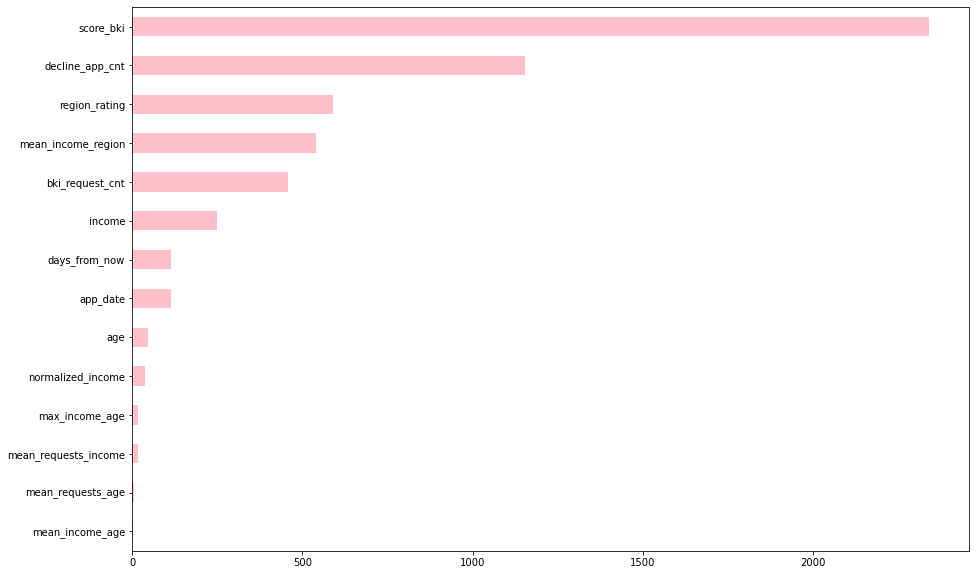

In [70]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color='pink')

Для категорильаных и бинарных

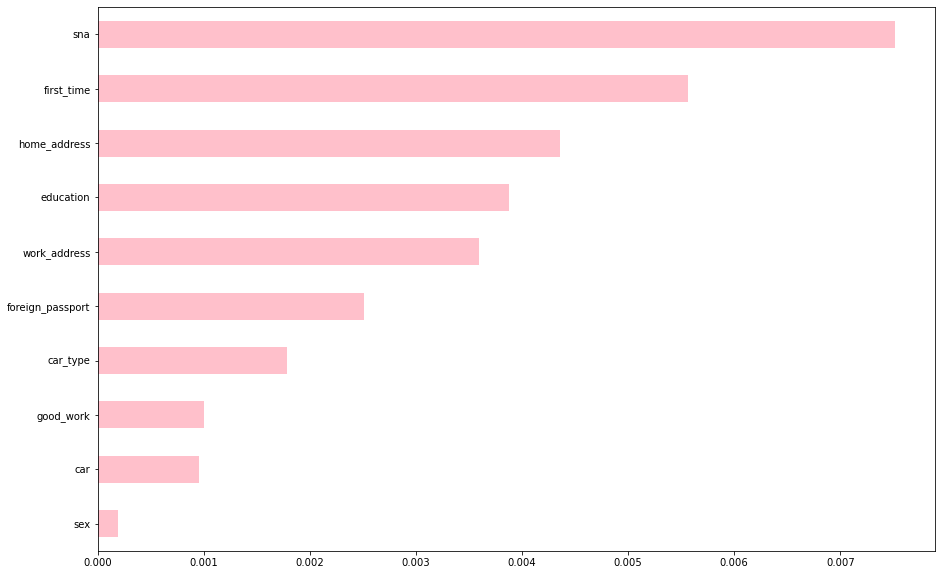

In [71]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols], data_temp['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color='pink')

# **Encoding**

In [72]:
df = pd.get_dummies(dataset, prefix=cat_cols, columns=cat_cols)

In [73]:
data = df.copy()

In [74]:
data.head(3)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,25905,-0.934391,0,1.975219,0,0,-0.418815,0,-0.208688,-0.281790,...,0,0,0,0,0,1,1,0,0,0
1,63161,0.281474,1,1.714757,1,1,-0.418815,0,0.745419,0.770563,...,1,0,0,0,0,1,1,0,0,0
2,25887,-0.934391,0,-1.237142,0,1,2.621662,0,0.993988,-0.281790,...,0,0,1,0,0,0,0,0,0,1


# **Построим модель**

1. **Oversampling**

In [75]:
data[data['default']!=-1].default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

В данных нет проблемы с дисбалансом, однако 64427/9372=6.9, значений default=0 больше в 7 раз чем, default=1, решим эту проблему, добавлением строк с default=1

In [76]:
# возьмём индексы всех строк с default=1
indexies_list = data[data['default']==1].index
len_default1 = len(indexies_list) # кол-во таких строк
# добавляем в dataframe эти строки для уравнивания
for i in range(0,6):
    data = data.append(data.loc[indexies_list][:len_default1], sort=False)

In [77]:
# Значения совпадают
data[data['default']!=-1].default.value_counts()

1    65604
0    64427
Name: default, dtype: int64

In [78]:
train_df = data.query('sample == 1').drop(['sample','client_id'], axis=1) # тренировочный датасет
test_df = data.query('sample == 0').drop(['sample','client_id'], axis=1) # тестовый, который нужен для submission

# разделим тренировочный датасет, на train и valid, чтобы оценивать значения метрик и прочее
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=31)

model = LogisticRegression(max_iter = 1000) # назначаем метод логистической классификации

model.fit(X_train, y_train) # тренируем модель на тренировочных данных
y_pred = model.predict(X_valid) # предсказываем на тестовых
y_pred_train = model.predict(X_train) #  предсказываем на тренировочных(чтобы посмотреть переобучение)

In [79]:
print('1 в valid:',len(np.where(y_valid==1)[0]))
print('0 в valid:',len(np.where(y_valid==0)[0]))
print('1 в train:',len(np.where(y_train==1)[0]))
print('0 в train:',len(np.where(y_train==0)[0]))

1 в valid: 13196
0 в valid: 12811
1 в train: 52408
0 в train: 51616


In [80]:
# метрики от валидации
print('accuracy_score:',accuracy_score(y_valid,y_pred))
print('precision_score:',precision_score(y_valid,y_pred))
print('recall_score:',recall_score(y_valid,y_pred))
print('f1_score:',f1_score(y_valid,y_pred))

accuracy_score: 0.678163571346176
precision_score: 0.6803977272727273
recall_score: 0.6896786905122765
f1_score: 0.6850067740478699


In [81]:
# метрики от трейна
print('accuracy_score:',accuracy_score(y_train,y_pred_train))
print('precision_score:',precision_score(y_train,y_pred_train))
print('recall_score:',recall_score(y_train,y_pred_train))
print('f1_score:',f1_score(y_train,y_pred_train))

accuracy_score: 0.6752095670229947
precision_score: 0.674193669086283
recall_score: 0.6876240268661273
f1_score: 0.6808426223313812


# **Confusion matrix**

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

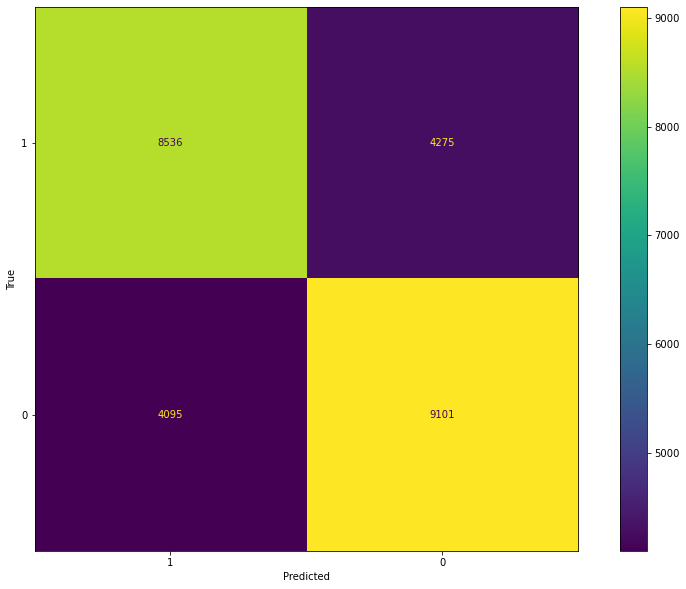

In [82]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Значения метрик не отличаются(от валидации не меньше, чем от трейна), значит нет переобучения.

Соотношения хорошие, дисбаланса нет.

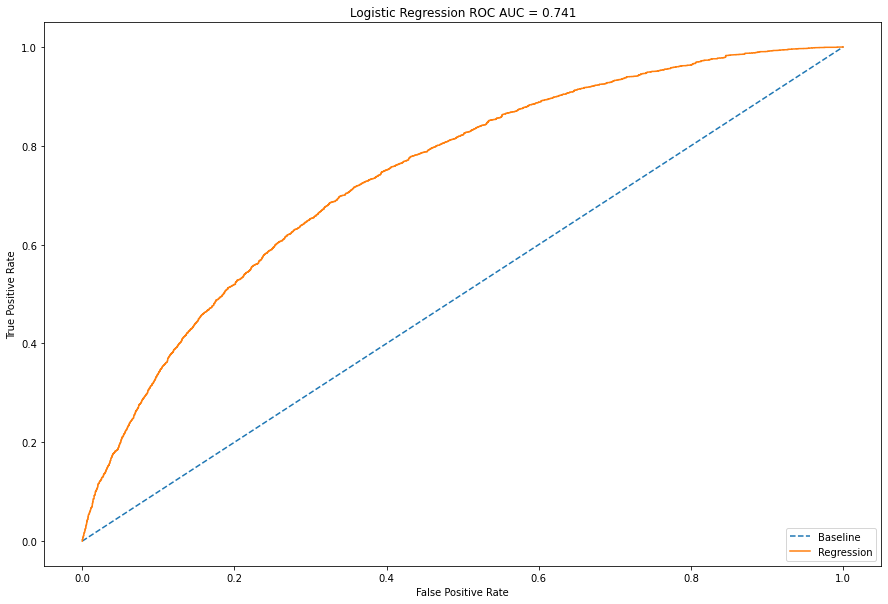

In [83]:
probs = model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# **Подбираем гиперпараметры**

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
C = np.logspace(0, 4, 10)
penalty = ['l1', 'l2']

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_valida

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_mo

Лучшее Penalty: l2
Лучшее C: 464.15888336127773


In [86]:
best_model.best_estimator_.get_params()

{'C': 464.15888336127773,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [87]:
train_df = data.query('sample == 1').drop(['sample','client_id'], axis=1) # тренировочный датасет
test_df = data.query('sample == 0').drop(['sample','client_id'], axis=1) # тестовый, который нужен для submission

# разделим тренировочный датасет, на train и valid, чтобы оценивать значения метрик и прочее
X = train_df.drop(['default'], axis=1).values
y = train_df['default'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=31)

model = LogisticRegression(C=464, penalty='l2') # назначаем метод логистической классификации

model.fit(X_train, y_train) # тренируем модель на тренировочных данных
y_pred = model.predict(X_valid) # предсказываем на тестовых
y_pred_train = model.predict(X_train) #  предсказываем на тренировочных(чтобы посмотреть переобучение)

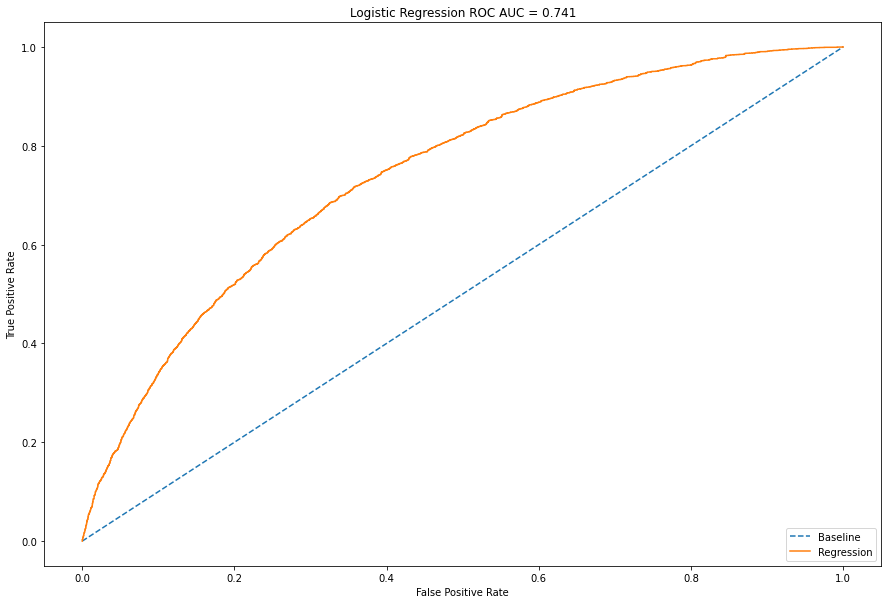

In [88]:
probs = model.predict_proba(X_valid)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

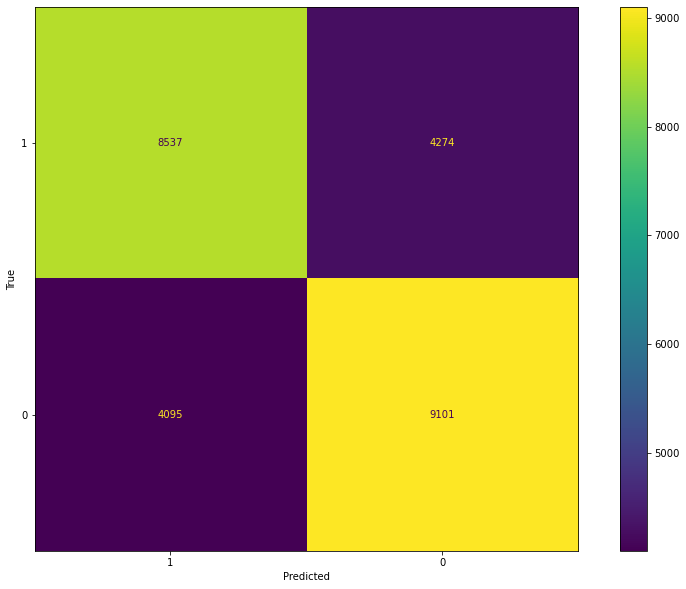

In [89]:
cm = confusion_matrix(y_valid, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [90]:
X_test = test_df.drop(['default'], axis=1)
y_pred = model.predict_proba(X_test)[:,1]
submission = pd.DataFrame(data={'client_id':test['client_id'], 'default':y_pred})

In [91]:
submission.to_csv('submission.csv', index=False)

In [92]:
submission.head(5)

,client_id,default
0,74835,0.244162
1,17527,0.787958
2,75683,0.350011
3,26883,0.401657
4,28862,0.111315
